Run PifPaf pose tracking model for BBS RGB images.  (generating virtual video stream vis cv2.VideoCapture)

In [1]:
import io
import numpy as np
import PIL
import requests
import torch
import cv2

import openpifpaf as opf

# Video 

In [2]:
import json
import logging
import os
import time

import torch

from openpifpaf import decoder, logger, network, show, visualizer, __version__
from openpifpaf.predictor import Predictor
from openpifpaf.stream import Stream

from glob import glob

class dummy():
    def __init__(self):
        pass
args = dummy()


LOG = logging.getLogger(__name__)

Stream loader 분석

2298
(5, 264, 12, 3)
[('cam', '<i8'), ('cnt', '<i8'), ('class', '<i8'), ('score', '<i8')]


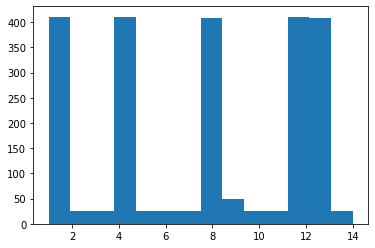

In [41]:
import matplotlib.pyplot as plt 

glob_str = "./g1/e/*/BBS/RGB/*/*/*"
fnlist = glob(glob_str)

cam_code = {'a':1, 'e':5}

flist = np.zeros(len(fnlist), dtype=[('cam', int), ('cnt', int), ('class', int), ('score', int)])

for i, fn in enumerate(fnlist):
    _,_,cam, num, _, _, char, action, score=fn.split("/")
    flist[i]['cam'] = cam_code[cam]
    flist[i]['cnt'] = int(num)
    flist[i]['class'] = int(action)
    flist[i]['score'] = int(score)

print(len(flist))
print(flist[0])
print(flist.dtype)

plt.hist(flist["class"], bins=14)
plt.show()

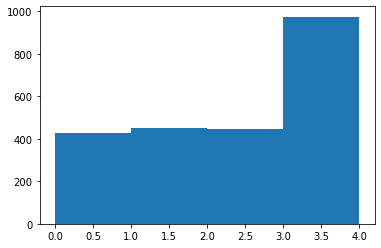

In [42]:
plt.hist(flist["score"], bins=4)
plt.show()

In [3]:
#for i_f, fn in enumerate(fnlist):
args.separate_debug_ax=False
args.debug_indices=None
args.batch_size=4
args.decoder_workers=4

out_dir = '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/Preds/'

glob_str = "./g1/[a,e]/???/BBS/RGB/*/*/*" # All RGB images recorded by a and e cameras
done=[]

fnlist = [fn for fn in glob(glob_str) if fn not in done]
fnlist.sort()

for fn in fnlist:
    _,_,cam, num, _, _, char, action, score=fn.split("/")   
    
    args.json_output = out_dir + f"{cam}_{num}_{char}_{action}_{score}.json"
    args.video_output = [None, "output.mp4"][0]
    args.source = fn+'/%4d.jpg'

    Predictor.loader_workers = 1
    predictor = Predictor(
        visualize_image=(not args.json_output or args.video_output),
        visualize_processed_image=None,
    )

    capture = Stream(args.source, preprocess=predictor.preprocess)

    annotation_painter = show.AnnotationPainter()
    animation = show.AnimationFrame(
        video_output=args.video_output,
        second_visual=args.separate_debug_ax,
    )
    if not args.json_output or args.video_output:
        ax, ax_second = animation.frame_init()
        visualizer.Base.common_ax = ax_second if args.separate_debug_ax else ax

    last_loop = time.perf_counter()
    for (ax, ax_second), (preds, _, meta) in \
            zip(animation.iter(), predictor.dataset(capture)):
        start_post = time.perf_counter()
        if args.json_output:
            with open(args.json_output, 'a+') as f:
                json.dump({
                    'frame': meta['frame_i'],
                    'predictions': [ann.json_data() for ann in preds]
                }, f, separators=(',', ':'))
                f.write('\n')
        if (not args.json_output or args.video_output) \
           and (args.separate_debug_ax or not args.debug_indices):
            image = visualizer.Base.image()
            ax.imshow(image)
            annotation_painter.annotations(ax, preds)
        postprocessing_time = time.perf_counter() - start_post
        if animation.last_draw_time is not None:
            postprocessing_time += animation.last_draw_time

        LOG.info('frame %d, loop time = %.0fms (pre = %.1fms, post = %.1fms), FPS = %.1f',
                 meta['frame_i'],
                 (time.perf_counter() - last_loop) * 1000.0,
                 meta['preprocessing_s'] * 1000.0,
                 postprocessing_time * 1000.0,
                 1.0 / (time.perf_counter() - last_loop))
        last_loop = time.perf_counter()
    
    done.append(fn)
    if len(done) % 100 ==99:
        # update fnlist every 100 vides
        fnlist = [fn for fn in glob(glob_str) if fn not in done]
        fnlist.sort()
    if len(fnlist) == 0:
        break

/home/hoseung/Work/openpifpaf/src/openpifpaf/csrc/src/cif_hr.cpp:102: UserInfo: resizing cifhr buffer
/home/hoseung/Work/openpifpaf/src/openpifpaf/csrc/src/occupancy.cpp:53: UserInfo: resizing occupancy buffer


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hoseung/anaconda3/envs/deepinsight/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_648508/1681945897.py", line 40, in <module>
    for (ax, ax_second), (preds, _, meta) in \
  File "/home/hoseung/Work/openpifpaf/src/openpifpaf/predictor.py", line 116, in dataset
    yield from self.dataloader(dataloader)
  File "/home/hoseung/Work/openpifpaf/src/openpifpaf/predictor.py", line 155, in dataloader
    yield from self.enumerated_dataloader(enumerate(dataloader))
  File "/home/hoseung/Work/openpifpaf/src/openpifpaf/predictor.py", line 129, in enumerated_dataloader
    pred_batch = self.processor.batch(self.model, processed_image_batch, device=self.device)
  File "/home/hoseung/Work/openpifpaf/src/openpifpaf/decoder/decoder.py", line 117, in batch
    fields_batch = self.fields_batch(model, image_batch, device=device)
  File "/hom

TypeError: object of type 'NoneType' has no len()